In [1]:
import numpy as np  
import os  
import pickle as pickle  
import glob  
import matplotlib.pyplot as plt  

In [4]:
data_dir = "/Users/irisjiang/FDU/1-2/神经网络/hw/nn_mid/"  
data_dir_cifar100 = os.path.join(data_dir, "cifar-100-python")  

class_names_cifar100 = np.load(os.path.join(data_dir_cifar100, "meta"),allow_pickle=True)  

In [5]:
class_names_cifar100

{'fine_label_names': ['apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel

In [6]:
len(class_names_cifar100['coarse_label_names'])

20

In [8]:
def one_hot(x, n):  
    x = np.array(x)  
    assert x.ndim == 1  
    return np.eye(n)[x]  
  
def _grayscale(a):  
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)  
  
def _load_batch_cifar100(filename, dtype='float64'):  
    path = os.path.join(data_dir_cifar100, filename)  
    batch = np.load(path,encoding='bytes',allow_pickle=True)  
    data = batch[b'data'] / 255.0  
    labels = one_hot(batch[b'fine_labels'], n=100)  
    return data.astype(dtype), labels.astype(dtype)  
  
def cifar100(dtype='float64', grayscale=True):  
    x_train, t_train = _load_batch_cifar100("train", dtype=dtype)  
    x_test, t_test = _load_batch_cifar100("test", dtype=dtype)  
    return x_train, t_train, x_test, t_test  

In [9]:
Xtrain, Ytrain, Xtest, Ytest = cifar100()  

In [10]:
Xtrain

array([[1.        , 1.        , 1.        , ..., 0.03921569, 0.23137255,
        0.30980392],
       [1.        , 0.99215686, 0.99215686, ..., 0.99215686, 0.99215686,
        1.        ],
       [0.98039216, 0.97254902, 0.96862745, ..., 0.76078431, 0.81176471,
        0.89411765],
       ...,
       [0.97254902, 0.94117647, 0.9254902 , ..., 0.70588235, 0.68235294,
        0.80392157],
       [0.61176471, 0.59215686, 0.59215686, ..., 0.44705882, 0.41960784,
        0.49411765],
       [0.12156863, 0.11764706, 0.12156863, ..., 0.28235294, 0.27058824,
        0.2627451 ]])

In [11]:
Xtrain.shape

(50000, 3072)

In [17]:
img = _grayscale(Xtrain).reshape(50000,32,32,1)

In [18]:
img_test = img[:32,:,:,:]

### 前32个图片

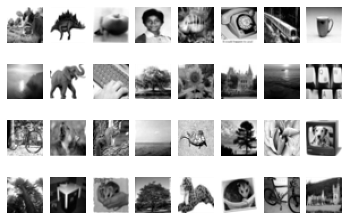

In [19]:
plt.figure()
for i in range(1,33):
    plt.subplot(4,8,i)
    plt.imshow(img_test[i-1],cmap="gray")
    plt.axis('off')
plt.show()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as  transforms
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [22]:
train = datasets.CIFAR100(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test = datasets.CIFAR100(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class AlexNet(nn.Module):


    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            #input:3*32*32
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            #input:96*16*16
            nn.MaxPool2d(kernel_size=2, stride=2),
            #input:96*8*8
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1,padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            #input:256*8*8
            nn.MaxPool2d(kernel_size=2, stride=2),
            #input:256*4*4
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #input:384*4*4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #input:384*4*4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #input:384*4*4
            nn.MaxPool2d(kernel_size=2, stride=2)
            #output:384*2*2
        )
 
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.5),
            nn.Linear(in_features=(384 * 2 * 2), out_features=1536),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1536, out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=100),
        )



    def forward(self, inputs):
        x = self.features(inputs)
        x = x.view(-1, 384 * 2 * 2)
        x = self.classifier(x)
        return x


In [24]:
from torchsummary import summary
from torch.autograd import Variable
import time as time

In [25]:
# 显示网络参数量
def Init_net():
    model = AlexNet()
    data_input = Variable(torch.randn(8,3,32,32))
    print(data_input.size())
    model(data_input)
    print(summary(model,(3,32,32)))

In [26]:
Init_net()

torch.Size([8, 3, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           7,296
              ReLU-2           [-1, 96, 16, 16]               0
 LocalResponseNorm-3           [-1, 96, 16, 16]               0
         MaxPool2d-4             [-1, 96, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         614,656
              ReLU-6            [-1, 256, 8, 8]               0
 LocalResponseNorm-7            [-1, 256, 8, 8]               0
         MaxPool2d-8            [-1, 256, 4, 4]               0
            Conv2d-9            [-1, 384, 4, 4]         885,120
             ReLU-10            [-1, 384, 4, 4]               0
           Conv2d-11            [-1, 384, 4, 4]       1,327,488
             ReLU-12            [-1, 384, 4, 4]               0
           Conv2d-13            [-1, 384, 4, 4]       1,327,488
            

In [ ]:
def cutmix(batch, alpha):
    data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets

### 选取三个图片进行数据增强

In [27]:
test1 = train[0]
test2 = train[200]
test3 = train[10000]

In [40]:
## 取出图片数据
pic1 = test1[0]
pic2 = test2[0]
pic3 = test3[0]
image_batch = [pic1,pic2,pic3]
image_batch_labels = [test1[1],test2[1],test3[1]]

In [29]:
def swapaxes(a):
    a = a.swapaxes(0, 1)
    a = a.swapaxes(1, 2)
    return a

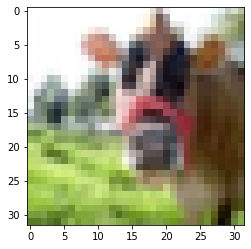

In [31]:
plt.imshow(swapaxes(pic1))

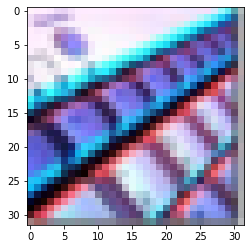

In [32]:
plt.imshow(swapaxes(pic2))

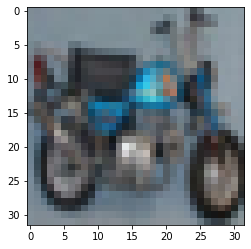

In [33]:
plt.imshow(swapaxes(pic3))

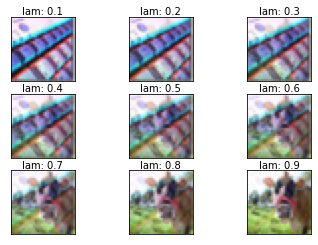

In [36]:
### mixup
for i in range(1,10):
    lam= i*0.1
    im_mixup = (pic1*lam+pic2*(1-lam))
    plt.subplot(3,3,i)
    plt.title("lam: {}".format(round(0.1*i,1)),fontsize=10, pad=2)
    plt.imshow(swapaxes(im_mixup))
    plt.xticks([])
    plt.yticks([])
plt.show()

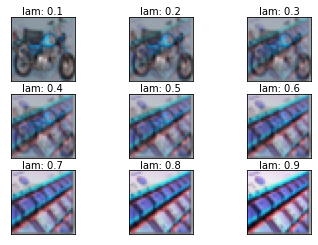

In [37]:
for i in range(1,10):
    lam= i*0.1
    im_mixup = (pic2*lam+pic3*(1-lam))
    plt.subplot(3,3,i)
    plt.title("lam: {}".format(round(0.1*i,1)),fontsize=10, pad=2)
    plt.imshow(swapaxes(im_mixup))
    plt.xticks([])
    plt.yticks([])
plt.show()

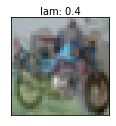

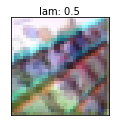

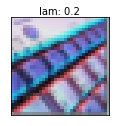

In [47]:
##取任意值
rand_index = np.random.permutation(3)
for i in range(3):
    lam = np.random.beta(0.5, 0.5)
    im_mixup = (image_batch[i]*lam+image_batch[rand_index[i]]*(1-lam))
    plt.subplot(1,3,i+1)
    plt.title("lam: {}".format(round(lam,1)),fontsize=10, pad=2)
    plt.imshow(swapaxes(im_mixup))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [55]:
import copy

In [477]:
train[0][0].shape

torch.Size([3, 32, 32])

In [56]:
def rand_patch(size, lam):
    H = size[1]
    W = size[2]

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    px1 = np.clip(cx - cut_w // 2, 0, W)
    py1 = np.clip(cy - cut_h // 2, 0, H)
    px2 = np.clip(cx + cut_w // 2, 0, W)
    py2 = np.clip(cy + cut_h // 2, 0, H)

    return px1, py1, px2, py2

In [57]:
def generate_cutmix_image(image_batch, image_batch_labels, alpha):
    # generate mixed sample
    lam = np.random.beta(alpha, alpha)
    rand_index = np.random.permutation(len(image_batch))
    px1, py1, px2, py2 = rand_patch(image_batch[0].shape, lam)
    image_batch_update = copy.deepcopy(image_batch)
    batch_final = []

    for i in range(len(image_batch)):
        image_batch_update[i][:,px1:px2, py1:py2] = image_batch[rand_index[i]][:,px1:px2, py1:py2]
        labels = [image_batch_labels[i],image_batch_labels[rand_index[i]]]
        tup = (image_batch_update[i],labels)
        batch_final.append(tup)
    return batch_final,lam

In [58]:
cutmiximg,lam= generate_cutmix_image(image_batch, image_batch_labels,0.5)

/var/folders/pr/fszw1bfs4l3_gds2ksx8rnbr0000gn/T/ipykernel_12008/1456153614.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
/var/folders/pr/fszw1bfs4l3_gds2ksx8rnbr0000gn/T/ipykernel_12008/1456153614.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

### cutmix效果可视化

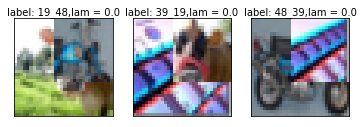

In [59]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(swapaxes(cutmiximg[i][0]))
    plt.xticks([])
    plt.yticks([])
    plt.title("label: {}_{},lam = {}".format(cutmiximg[i][1][0],cutmiximg[i][1][1],round(lam,1)),fontsize=10, pad=2)
plt.show()

### cutout结果可视化

In [71]:
# n_hole=1,length=16
def cutout_one(img):     
    h = img.size(1)
    w = img.size(2)
    mask = np.ones((h, w), np.float32)
    for n in range(1):
        y = np.random.randint(h)  # 返回随机数/数组(整数)
        x = np.random.randint(w)
        y1 = np.clip(y - 16 // 2, 0, h) #截取函数
        y2 = np.clip(y + 16 // 2, 0, h) #⽤于截取数组中⼩于或者⼤于某值的部分，
        x1 = np.clip(x - 16 // 2, 0, w) #并使得被截取的部分等于固定的值
        x2 = np.clip(x + 16 // 2, 0, w)
        mask[y1: y2, x1: x2] = 0.
    mask = torch.from_numpy(mask)   #数组转换成张量，且⼆者共享内存，对张量进⾏修改⽐如重新赋值，那么原始数组也会相应发⽣改变
    mask = mask.expand_as(img)  #把⼀个tensor变成和函数括号内⼀样形状的tensor
    img = img * mask
    return img

In [72]:
cutout = Cutout(1,16)

In [73]:
co1 = cutout_one(test1[0])
co2 = cutout_one(test2[0])
co3 = cutout_one(test3[0])
box = [co1,co2,co3]

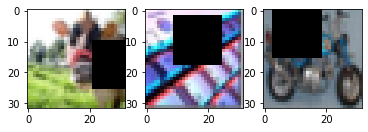

In [75]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(swapaxes(box[i]))
plt.show()